In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 포지셔널 인코딩 레이어

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, name="positional_encoding",**kwargs):
        super(PositionalEncoding, self).__init__(name=name,**kwargs)
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.position = position  
        self.d_model = d_model

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "position": self.position,
            "d_model": self.d_model
        })
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):

        # inputs가 SparseTensor인 경우 DenseTensor로 변환
        if isinstance(inputs, tf.sparse.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)

        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 멀티헤드어텐션 레이어

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention",**kwargs):
        super(MultiHeadAttention, self).__init__(name=name,**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
        })
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)  # (batch_size, seq_len, d_model)
        key = self.key_dense(key)  # (batch_size, seq_len, d_model)
        value = self.value_dense(value)  # (batch_size, seq_len, d_model)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

# 패딩 마스크

In [4]:
def create_padding_mask(x): # 숫자가 0인 부분 체크(1: 무시한다)
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):  # 다음 단어를 가린다. (1: 무시한다)
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # (seq_len, seq_len)
    look_ahead_mask = look_ahead_mask[tf.newaxis, tf.newaxis, :, :]   # (1, 1, seq_len, seq_len)
    padding_mask = create_padding_mask(x)  # (batch_size, 1, 1, seq_len)
    return tf.maximum(look_ahead_mask, padding_mask)

print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


# 인코더

In [5]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더

In [6]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 데이터 로드 & 전처리

불용어 리스트

https://deep.chulgil.me/hangugeo-bulyongeo-riseuteu/

In [7]:
stopwords ="""가
가까스로
가령
각
각각
각자
각종
갖고말하자면
같다
같이
개의치않고
거니와
거바
거의
것
것과 같이
것들
게다가
게우다
겨우
견지에서
결과에 이르다
결국
결론을 낼 수 있다
겸사겸사
고려하면
고로
곧
공동으로
과
과연
관계가 있다
관계없이
관련이 있다
관하여
관한
관해서는
구
구체적으로
구토하다
그
그들
그때
그래
그래도
그래서
그러나
그러니
그러니까
그러면
그러므로
그러한즉
그런 까닭에
그런데
그런즉
그럼
그럼에도 불구하고
그렇게 함으로써
그렇지
그렇지 않다면
그렇지 않으면
그렇지만
그렇지않으면
그리고
그리하여
그만이다
그에 따르는
그위에
그저
그중에서
그치지 않다
근거로
근거하여
기대여
기점으로
기준으로
기타
까닭으로
까악
까지
까지 미치다
까지도
꽈당
끙끙
끼익
나
나머지는
남들
남짓
너
너희
너희들
네
넷
년
논하지 않다
놀라다
누가 알겠는가
누구
다른
다른 방면으로
다만
다섯
다소
다수
다시 말하자면
다시말하면
다음
다음에
다음으로
단지
답다
당신
당장
대로 하다
대하면
대하여
대해 말하자면
대해서
댕그
더구나
더군다나
더라도
더불어
더욱더
더욱이는
도달하다
도착하다
동시에
동안
된바에야
된이상
두번째로
둘
둥둥
뒤따라
뒤이어
든간에
들
등
등등
딩동
따라
따라서
따위
따지지 않다
딱
때
때가 되어
때문에
또
또한
뚝뚝
라 해도
령
로
로 인하여
로부터
로써
륙
를
마음대로
마저
마저도
마치
막론하고
만 못하다
만약
만약에
만은 아니다
만이 아니다
만일
만큼
말하자면
말할것도 없고
매
매번
메쓰겁다
몇
모
모두
무렵
무릎쓰고
무슨
무엇
무엇때문에
물론
및
바꾸어말하면
바꾸어말하자면
바꾸어서 말하면
바꾸어서 한다면
바꿔 말하면
바로
바와같이
밖에 안된다
반대로
반대로 말하자면
반드시
버금
보는데서
보다더
보드득
본대로
봐
봐라
부류의 사람들
부터
불구하고
불문하고
붕붕
비걱거리다
비교적
비길수 없다
비로소
비록
비슷하다
비추어 보아
비하면
뿐만 아니라
뿐만아니라
뿐이다
삐걱
삐걱거리다
사
삼
상대적으로 말하자면
생각한대로
설령
설마
설사
셋
소생
소인
솨
쉿
습니까
습니다
시각
시간
시작하여
시초에
시키다
실로
심지어
아
아니
아니나다를가
아니라면
아니면
아니었다면
아래윗
아무거나
아무도
아야
아울러
아이
아이고
아이구
아이야
아이쿠
아하
아홉
안 그러면
않기 위하여
않기 위해서
알 수 있다
알았어
앗
앞에서
앞의것
야
약간
양자
어
어기여차
어느
어느 년도
어느것
어느곳
어느때
어느쪽
어느해
어디
어때
어떠한
어떤
어떤것
어떤것들
어떻게
어떻해
어이
어째서
어쨋든
어쩔수 없다
어찌
어찌됏든
어찌됏어
어찌하든지
어찌하여
언제
언젠가
얼마
얼마 안 되는 것
얼마간
얼마나
얼마든지
얼마만큼
얼마큼
엉엉
에
에 가서
에 달려 있다
에 대해
에 있다
에 한하다
에게
에서
여
여기
여덟
여러분
여보시오
여부
여섯
여전히
여차
연관되다
연이서
영
영차
옆사람
예
예를 들면
예를 들자면
예컨대
예하면
오
오로지
오르다
오자마자
오직
오호
오히려
와
와 같은 사람들
와르르
와아
왜
왜냐하면
외에도
요만큼
요만한 것
요만한걸
요컨대
우르르
우리
우리들
우선
우에 종합한것과같이
운운
월
위에서 서술한바와같이
위하여
위해서
윙윙
육
으로
으로 인하여
으로서
으로써
을
응
응당
의
의거하여
의지하여
의해
의해되다
의해서
이
이 되다
이 때문에
이 밖에
이 외에
이 정도의
이것
이곳
이때
이라면
이래
이러이러하다
이러한
이런
이럴정도로
이렇게 많은 것
이렇게되면
이렇게말하자면
이렇구나
이로 인하여
이르기까지
이리하여
이만큼
이번
이봐
이상
이어서
이었다
이와 같다
이와 같은
이와 반대로
이와같다면
이외에도
이용하여
이유만으로
이젠
이지만
이쪽
이천구
이천육
이천칠
이천팔
인 듯하다
인젠
일
일것이다
일곱
일단
일때
일반적으로
일지라도
임에 틀림없다
입각하여
입장에서
잇따라
있다
자
자기
자기집
자마자
자신
잠깐
잠시
저
저것
저것만큼
저기
저쪽
저희
전부
전자
전후
점에서 보아
정도에 이르다
제
제각기
제외하고
조금
조차
조차도
졸졸
좀
좋아
좍좍
주룩주룩
주저하지 않고
줄은 몰랏다
줄은모른다
중에서
중의하나
즈음하여
즉
즉시
지든지
지만
지말고
진짜로
쪽으로
차라리
참
참나
첫번째로
쳇
총적으로
총적으로 말하면
총적으로 보면
칠
콸콸
쾅쾅
쿵
타다
타인
탕탕
토하다
통하여
툭
퉤
틈타
팍
팔
퍽
펄렁
하
하게될것이다
하게하다
하겠는가
하고 있다
하고있었다
하곤하였다
하구나
하기 때문에
하기 위하여
하기는한데
하기만 하면
하기보다는
하기에
하나
하느니
하는 김에
하는 편이 낫다
하는것도
하는것만 못하다
하는것이 낫다
하는바
하더라도
하도다
하도록시키다
하도록하다
하든지
하려고하다
하마터면
하면 할수록
하면된다
하면서
하물며
하여금
하여야
하자마자
하지 않는다면
하지 않도록
하지마
하지마라
하지만
하하
한 까닭에
한 이유는
한 후
한다면
한다면 몰라도
한데
한마디
한적이있다
한켠으로는
한항목
할 따름이다
할 생각이다
할 줄 안다
할 지경이다
할 힘이 있다
할때
할만하다
할망정
할뿐
할수있다
할수있어
할줄알다
할지라도
할지언정
함께
해도된다
해도좋다
해봐요
해서는 안된다
해야한다
해요
했어요
향하다
향하여
향해서
허
허걱
허허
헉
헉헉
헐떡헐떡
형식으로 쓰여
혹시
혹은
혼자
훨씬
휘익
휴
흐흐
흥
힘입어"""
stopwords = stopwords.split()

In [38]:
import re

def preprocess_sentence(sentence):

    # 특수문자 제거
    sentence = re.sub("[^가-힣a-zA-Z0-9]+", " ", sentence)

    # normalize: 2번 이상 반복되는 한글문자 → 1개로 축소
    sentence = re.sub(r"([가-힣])\1{1,}", r"\1", sentence)

    # lower english
    sentence = sentence.lower()
    
    # 영어-한글 간격 확보
    sentence = re.sub(r"([a-zA-Z])([가-힣])", r"\1 \2", sentence)
    sentence = re.sub(r"([가-힣])([a-zA-Z])", r"\1 \2", sentence)
    
    tokens = sentence.split()
    tokens = [token for token in tokens if token not in stopwords]

    return " ".join(tokens).strip()

# 질문-응답 쌍 로드
def load_conversations_from_chatbot_csv(filepath, max_samples=20000):
    data = pd.read_csv(filepath)
    questions = []
    answers = []

    for i in tqdm(range(min(len(data), max_samples)), desc="Loading Q&A Pairs"):
        q = preprocess_sentence(data.loc[i, 'Q'])
        a = preprocess_sentence(data.loc[i, 'A'])
        questions.append(q)
        answers.append(a)
        if len(questions) >= max_samples:
            break
        if not q or not a:
            print(f"인덱스 : {i}")
            print(f"전처리 전 Q: {data.loc[i, 'Q']}")
            print(f"전처리 후 Q: {q}")
            print(f"전처리 전 A: {data.loc[i, 'A']}")
            print(f"전처리 후 A: {a}")
            print("-"*10)
    return questions, answers

In [40]:
data_path = os.path.expanduser('./data')
file_path = os.path.join(data_path, 'ChatbotData .csv')

questions, answers = load_conversations_from_chatbot_csv(file_path)
print(len(questions),len(answers))
print(questions[:30])
print(answers[:30])

Loading Q&A Pairs:  17%|█▋        | 2045/11823 [00:00<00:00, 10271.67it/s]

인덱스 : 157
전처리 전 Q: 결혼하면 좋아?
전처리 후 Q: 결혼하면
전처리 전 A: 해봐요.
전처리 후 A: 
----------
인덱스 : 165
전처리 전 Q: 결혼해야 하나
전처리 후 Q: 결혼해야
전처리 전 A: 해봐요.
전처리 후 A: 
----------
인덱스 : 517
전처리 전 Q: 나 어때?
전처리 후 Q: 
전처리 전 A: 괜찮은 사람이에요.
전처리 후 A: 괜찮은 사람이에요
----------
인덱스 : 925
전처리 전 Q: 너 누구?
전처리 후 Q: 
전처리 전 A: 저는 마음을 이어주는 위로봇입니다.
전처리 후 A: 저는 마음을 이어주는 위로봇입니다
----------
인덱스 : 1145
전처리 전 Q: 다음에 봐
전처리 후 Q: 
전처리 전 A: 잘가요.
전처리 후 A: 잘가요
----------
인덱스 : 1386
전처리 전 Q: 딱 좋아
전처리 후 Q: 
전처리 전 A: 현재를 즐기세요!
전처리 후 A: 현재를 즐기세요
----------


Loading Q&A Pairs:  35%|███▍      | 4126/11823 [00:00<00:00, 10229.01it/s]

인덱스 : 2995
전처리 전 Q: 야
전처리 후 Q: 
전처리 전 A: 네
전처리 후 A: 
----------
인덱스 : 3133
전처리 전 Q: 여기 좋아
전처리 후 Q: 
전처리 전 A: 좋은 곳인가봐요.
전처리 후 A: 좋은 곳인가봐요
----------
인덱스 : 3440
전처리 전 Q: 왜 안 하지
전처리 후 Q: 
전처리 전 A: 먼저 고백을 해보세요.
전처리 후 A: 먼저 고백을 해보세요
----------
인덱스 : 3621
전처리 전 Q: 응
전처리 후 Q: 
전처리 전 A: 네
전처리 후 A: 
----------
인덱스 : 3880
전처리 전 Q: 자?
전처리 후 Q: 
전처리 전 A: 기다리고 있었어요.
전처리 후 A: 기다리고 있었어요
----------
인덱스 : 4032
전처리 전 Q: 저기
전처리 후 Q: 
전처리 전 A: 딴짓 중입니다
전처리 후 A: 딴짓 중입니다
----------


Loading Q&A Pairs:  52%|█████▏    | 6173/11823 [00:00<00:00, 10133.00it/s]

인덱스 : 5099
전처리 전 Q: 헉
전처리 후 Q: 
전처리 전 A: 놀랐나봐요.
전처리 후 A: 놀랐나봐요
----------
인덱스 : 5832
전처리 전 Q: 남자가 못잊는 여자
전처리 후 Q: 남자가 못잊는 여자
전처리 전 A: 당신.
전처리 후 A: 
----------
인덱스 : 5872
전처리 전 Q: 내가 더 좋아하는 것
전처리 후 Q: 내가 더 좋아하는
전처리 전 A: 당신.
전처리 후 A: 
----------
인덱스 : 5974
전처리 전 Q: 너한테 이글안보여줄거다 .
전처리 후 Q: 너한테 이글안보여줄거다
전처리 전 A: 그렇게 해요.
전처리 후 A: 
----------
인덱스 : 6141
전처리 전 Q: 딱 좋아
전처리 후 Q: 
전처리 전 A: 현재를 즐기세요!
전처리 후 A: 현재를 즐기세요
----------
인덱스 : 6553
전처리 전 Q: 비오네
전처리 후 Q: 비오네
전처리 전 A: 주룩주룩.
전처리 후 A: 
----------
인덱스 : 6909
전처리 전 Q: 야
전처리 후 Q: 
전처리 전 A: 네
전처리 후 A: 
----------
인덱스 : 6910
전처리 전 Q: 야 너!
전처리 후 Q: 
전처리 전 A: 네
전처리 후 A: 
----------
인덱스 : 6993
전처리 전 Q: 어째서
전처리 후 Q: 
전처리 전 A: 어째서일까요.
전처리 후 A: 어째서일까요
----------
인덱스 : 7041
전처리 전 Q: 에휴.
전처리 후 Q: 에휴
전처리 전 A: 아이구.
전처리 후 A: 
----------


Loading Q&A Pairs:  69%|██████▉   | 8194/11823 [00:00<00:00, 9847.75it/s] 

인덱스 : 7228
전처리 전 Q: 왜
전처리 후 Q: 
전처리 전 A: 궁금하네요.
전처리 후 A: 궁금하네요
----------
인덱스 : 8120
전처리 전 Q: 젠장
전처리 후 Q: 젠장
전처리 전 A: 이런.
전처리 후 A: 
----------
인덱스 : 8395
전처리 전 Q: 하.
전처리 후 Q: 
전처리 전 A: 힘내세요.
전처리 후 A: 힘내세요
----------
인덱스 : 8758
전처리 전 Q: 혼자ㅠㅠㅠ
전처리 후 Q: 
전처리 전 A: 많이 힘들어하지 마요.
전처리 후 A: 많이 힘들어하지 마요
----------
인덱스 : 8783
전처리 전 Q: 후
전처리 후 Q: 
전처리 전 A: 힘을 내세요.
전처리 후 A: 힘을 내세요
----------
인덱스 : 8787
전처리 전 Q: 후.ㅎㅎ
전처리 후 Q: 
전처리 전 A: 지쳤나봐요.
전처리 후 A: 지쳤나봐요
----------
인덱스 : 8806
전처리 전 Q: 휴
전처리 후 Q: 
전처리 전 A: 아이구
전처리 후 A: 
----------


Loading Q&A Pairs: 100%|██████████| 11823/11823 [00:01<00:00, 9512.06it/s]

인덱스 : 11205
전처리 전 Q: 좋아하는 애한테 찌르기 눌러 버림.
전처리 후 Q: 좋아하는 애한테 찌르기 눌러 버림
전처리 전 A: 아이쿠.
전처리 후 A: 
----------
인덱스 : 11389
전처리 전 Q: 짝남이 내가 좋아하는 거 알아버림.
전처리 후 Q: 짝남이 내가 좋아하는 거 알아버림
전처리 전 A: 이런.
전처리 후 A: 
----------
11823 11823
['12시 땡', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네', 'sd 카드 망가졌어', 'sd 카드 안돼', 'sns 맞팔 안하지', 'sns 시간낭비인 거 아는데 매일 중', 'sns 시간낭비인데 자꾸 보게됨', 'sns 나만 빼고 다 행복해보여', '가끔 궁금해', '가끔 뭐하는지 궁금해', '가끔은 혼자인게 좋다', '가난한 자의 설움', '가만 있어도 땀난다', '가상화폐 쫄딱 망함', '가스불 켜고 나갔어', '가스불 켜놓고 나온거 같아', '가스비 너무 많이 나왔다', '가스비 비싼데 감기 걸리겠어', '가스비 장난 아님', '가장 확실한 건 뭘까', '가족 여행 가기로 했어', '가족 여행 고', '가족 여행 어디로 가지', '가족 있어', '가족관계 알려 줘', '가족끼리 여행간다', '가족들 보고 싶어']
['하루가 가네요', '위로해 드립니다', '여행은 언제나 좋죠', '여행은 언제나 좋죠', '눈살이 찌푸려지죠', '새로 사는 게 마음 편해요', '새로 사는 게 마음 편해요', '잘 모르고 있을 수도 있어요', '시간을 정하고 해보세요', '시간을 정하고 해보세요', '자랑하는 자리니까요', '사람도 그럴 거예요', '사람도 그럴 거예요', '혼자를 즐기세요', '돈은 들어올 거예요', '땀을 식혀주세요', '어서 잊고 새출발 하세요', '빨리 집에 돌아가서 끄고 나오세요', '빨리 집에 돌아가서 끄고 나오세요', '달에는 더 절약해봐요', '따뜻하게 사세요', '달에는 더 절약해봐요', '

In [26]:
# 전처리 완료 후 저장
df = pd.DataFrame({
    'Q': questions,
    'A': answers
})

# 저장 경로 설정
save_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/preprocessed_chatbot.csv')

# 저장
df.to_csv(save_path, index=False, encoding='utf-8-sig')  # Windows 호환 시 utf-8-sig
print(f" {save_path}")

 /aiffel/aiffel/transformer_chatbot/data/preprocessed_chatbot.csv


# 전처리 후 데이터 로드

In [43]:
save_path = os.path.expanduser('~/aiffel/transformer_chatbot/data/preprocessed_chatbot.csv')
df = pd.read_csv(save_path)
print(len(df))

11823


In [44]:
mask = df[['Q', 'A']].isna().any(axis=1)
print(df[mask])

                        Q                   A
157                  결혼하면                 NaN
165                  결혼해야                 NaN
517                   NaN           괜찮은 사람이에요
925                   NaN  저는 마음을 이어주는 위로봇입니다
1145                  NaN                 잘가요
1386                  NaN            현재를 즐기세요
2995                  NaN                 NaN
3133                  NaN            좋은 곳인가봐요
3440                  NaN         먼저 고백을 해보세요
3621                  NaN                 NaN
3880                  NaN           기다리고 있었어요
4032                  NaN             딴짓 중입니다
5099                  NaN               놀랐나봐요
5832           남자가 못잊는 여자                 NaN
5872            내가 더 좋아하는                 NaN
5974         너한테 이글안보여줄거다                 NaN
6141                  NaN            현재를 즐기세요
6553                  비오네                 NaN
6909                  NaN                 NaN
6910                  NaN                 NaN
6993                  NaN         

In [45]:
df = df.dropna(subset=['Q', 'A'])  #  하나라도 NaN이면 해당 행 삭제

# 리스트로 변환
questions = df['Q'].tolist()
answers = df['A'].tolist()

# 확인
print(len(questions), len(answers))

11792 11792


# 데이터 인코딩

In [46]:
import tensorflow_datasets as tfds

In [47]:
# 전체 문장 리스트 (질문 + 답변)
corpus = questions + answers

# SubwordTextEncoder 학습
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=2**13 
)

EOS ,SOS 토큰 추가

In [48]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

print(VOCAB_SIZE)
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('Vocab 예시:',tokenizer.subwords[:30])

8035
START_TOKEN의 번호 : [8033]
END_TOKEN의 번호 : [8034]
Vocab 예시: ['거예요', '게_', '너무_', '더_', '는_', '거_', '좋아하는_', '을_', '잘_', '도_', '이_', '고_', '많이_', '요', '좋은_', '같아요', '싶어', '가_', '있을_', '있어요', '지_', '에_', '해보세요', '은_', '사람_', '같아', '해', '네', '면_', '건_']


In [49]:
question_lens = [len(START_TOKEN + tokenizer.encode(q) + END_TOKEN) for q in questions]
answer_lens = [len(START_TOKEN + tokenizer.encode(a) + END_TOKEN) for a in answers]

print("질문 토큰 길이")
print("최대:", max(question_lens))
print("평균:", sum(question_lens) / len(question_lens))

print("답변 토큰 길이")
print("최대:", max(answer_lens))
print("평균:", sum(answer_lens) / len(answer_lens))

질문 토큰 길이
최대: 22
평균: 6.805630936227951
답변 토큰 길이
최대: 26
평균: 6.49024762550882


In [50]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이 설정
MAX_LENGTH = 30
print(MAX_LENGTH)

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 Maxlen 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 maxlen으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

30


In [51]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8035
필터링 후의 질문 샘플 개수: 11792
필터링 후의 답변 샘플 개수: 11792


In [85]:
for i in range(10):
    token_ids = questions[i].tolist()  # numpy array → list

    subwords = []
    for token in token_ids:
        if token == 0:
            subwords.append("[PAD]")
        elif token == tokenizer.vocab_size:
            subwords.append("[START]")
        elif token == tokenizer.vocab_size + 1:
            subwords.append("[END]")
        elif token < tokenizer.vocab_size:
            subwords.append(tokenizer.decode([token]))
        else:
            subwords.append("[UNK]")

    decoded_sentence = tokenizer.decode([t for t in token_ids if t < tokenizer.vocab_size])

    print("Token :", token_ids)
    print("Subword :", subwords)
    print("Decoded Sentence :", decoded_sentence)
    print("-" * 60)


Token : [8033, 7775, 2473, 2940, 8034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Subword : ['[START]', '12', '시 ', '땡', '[END]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Decoded Sentence : 12시 땡
------------------------------------------------------------
Token : [8033, 7826, 35, 845, 7809, 924, 1631, 8034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Subword : ['[START]', '1', '지', '망', ' ', '학교 ', '떨어졌어', '[END]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Decoded Sentence : 1지망 학교 떨어졌어
------------------------------------------------------------
Token : [8033, 7828, 1353, 4540, 7809, 3530, 48, 803

# Dataset 만들기

In [53]:
from sklearn.model_selection import train_test_split

train_q, val_q, train_a, val_a = train_test_split(
    questions, answers, test_size=0.2, random_state=42
)

In [54]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_q,
        'dec_inputs': train_a[:, :-1]
    },
    {
        'outputs': train_a[:, 1:]
    }
))

train_dataset = train_dataset.cache() #	처음 한 번 로딩 후, 메모리/디스크에 저장하여 속도 향상
train_dataset = train_dataset.shuffle(BUFFER_SIZE) #학습 데이터 무작위 섞기 (일반적으로 큰 값 사용)
train_dataset = train_dataset.batch(BATCH_SIZE) #배치 단위로 묶기 (여기선 64개씩)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)# 다음 배치를 미리 준비해서 GPU idle 시간 방지


val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_q,
        'dec_inputs': val_a[:, :-1]
    },
    {
        'outputs': val_a[:, 1:]
    }
)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

for batch in train_dataset.take(1):
    print("inputs shape:", batch[0]['inputs'].shape)
    print("dec_inputs shape:", batch[0]['dec_inputs'].shape)
    print("outputs shape:", batch[1]['outputs'].shape)
    print("inputs dtype:", batch[0]['inputs'].dtype)
    print("dec_inputs dtype:", batch[0]['dec_inputs'].dtype)
    print("outputs dtype:", batch[1]['outputs'].dtype)

inputs shape: (64, 30)
dec_inputs shape: (64, 29)
outputs shape: (64, 29)
inputs dtype: <dtype: 'int32'>
dec_inputs dtype: <dtype: 'int32'>
outputs dtype: <dtype: 'int32'>


# Transformer model 

In [55]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    # 1. 입력 레이어 정의
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 2. 마스크 생성
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 future token 차단 + padding도 같이 차단
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더 내부에서 인코더 출력을 참고할 때 padding 위치 무시
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)


    # 인코더 호출
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더 호출
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 출력층: 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    # 모델 반환
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [56]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3111168     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

# Custom Loss, Schedular

In [57]:
#레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


Text(0.5, 0, 'Train Step')

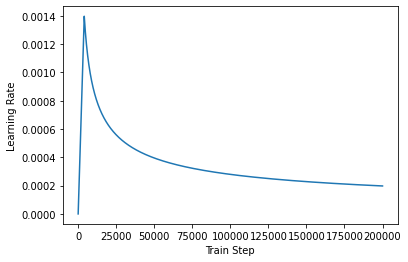

In [58]:
# 커스텀 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000,**kwargs):
        super(CustomSchedule, self).__init__( **kwargs)

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 학습

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [61]:
# EarlyStopping: val_loss 기준, patience=3
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True 
)

In [62]:
# 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
148/148 [==============================] - 15s 60ms/step - loss: 1.6040 - accuracy: 0.0275 - val_loss: 1.5046 - val_accuracy: 0.0345
Epoch 2/30
148/148 [==============================] - 8s 52ms/step - loss: 1.4255 - accuracy: 0.0345 - val_loss: 1.3510 - val_accuracy: 0.0345
Epoch 3/30
148/148 [==============================] - 8s 53ms/step - loss: 1.2963 - accuracy: 0.0345 - val_loss: 1.2702 - val_accuracy: 0.0348
Epoch 4/30
148/148 [==============================] - 8s 53ms/step - loss: 1.2181 - accuracy: 0.0361 - val_loss: 1.2056 - val_accuracy: 0.0377
Epoch 5/30
148/148 [==============================] - 8s 53ms/step - loss: 1.1519 - accuracy: 0.0392 - val_loss: 1.1669 - val_accuracy: 0.0399
Epoch 6/30
148/148 [==============================] - 8s 52ms/step - loss: 1.0921 - accuracy: 0.0426 - val_loss: 1.1262 - val_accuracy: 0.0437
Epoch 7/30
148/148 [==============================] - 8s 52ms/step - loss: 1.0279 - accuracy: 0.0474 - val_loss: 1.0882 - val_accuracy: 0.047

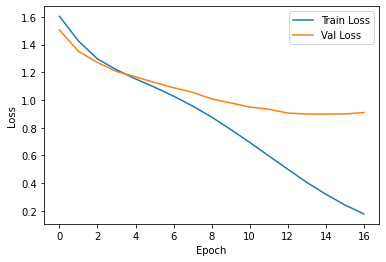

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Inference

In [64]:
def decoder_inference(sentence):
    # 입력받은 문장 전처리
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}\n'.format(predicted_sentence))

    return predicted_sentence

In [84]:
# 테스트 문장 실행
test_sentences = [
    "오늘 뭐 먹지?",
    "내일은 시험이 있는 날이야",
    "친구들과 여행을 가기로 했어",
    "시간 있으면 잠깐 볼래요?",
    "요즘 데이트하기 정말 좋은 날씨인듯",
    "오늘 날씨가 정말 좋은것 같아!",
    "커피 한 잔 마시면서 힐링하고 싶다."
]
results = [sentence_generation(s)for s in test_sentences]

입력 : 오늘 뭐 먹지?
출력 : 냉장고 파먹기 해보세요

입력 : 내일은 시험이 있는 날이야
출력 : 컨디션 조절 하세요

입력 : 친구들과 여행을 가기로 했어
출력 : 많이 만나보세요

입력 : 시간 있으면 잠깐 볼래요?
출력 : 제가 있잖아요

입력 : 요즘 데이트하기 정말 좋은 날씨인듯
출력 : 뭘 입어도 멋져요

입력 : 오늘 날씨가 정말 좋은것 같아!
출력 : 새로운 사랑을 하셨네요

입력 : 커피 한 잔 마시면서 힐링하고 싶다.
출력 : 건강에 좋을 거예요



# 회고

- 전처리 단계에서 한국어 텍스트를 처리하는 방법들을 찾아봤는데, 
    툴들이 많은 반면에 한 번에 정리된 라이브러리나 프레임워크는 드문 편이다.
- 대표적으로 konlpy, khaiii등을 많이 사용하는 것 같다 - konlpy는 사용해봤는데 khaiii는 한번도 안써봤다. 다음에 한번 써봐야겠다.
- 현재도 활발히 유지 관리되는 툴은 많지 않아, 사용 전 레포지토리나 릴리즈 정보를 확인하는 것이 좋다.

- stopwords 
https://deep.chulgil.me/hangugeo-bulyongeo-riseuteu/


- 이번 프로젝트에서는 SubwordTextEncoder 기반으로 임베딩을 구성했기 때문에 
    형태소 분석은 사용하지 않고 기본적인 전처리만 사용했다. 

- 현재 사용된 데이터셋의 크기가 상대적으로 작아, 학습된 모델이 다양한 상황을 학습하는 데 한계가 있었다.

